In [0]:
!pip install openmeteo-requests --quiet
!pip install requests-cache retry-requests numpy pandas --quiet

You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-0244bbd6-6496-40ee-b3a4-78fcb916de7d/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-0244bbd6-6496-40ee-b3a4-78fcb916de7d/bin/python -m pip install --upgrade pip' command.


In [0]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry

In [0]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://historical-forecast-api.open-meteo.com/v1/forecast"
params = {
	"latitude": -23.5475,
	"longitude": -46.6361,
	"start_date": "2025-01-01",
	"end_date": "2025-04-02",
	"hourly": ["temperature_2m", "relative_humidity_2m", "precipitation", "wind_speed_10m", "pressure_msl"]
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()}{response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(2).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(3).ValuesAsNumpy()
hourly_pressure_msl = hourly.Variables(4).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["precipitation"] = hourly_precipitation
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["pressure_msl"] = hourly_pressure_msl

hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)

Coordinates -23.5°N -46.5°E
Elevation 745.0 m asl
Timezone NoneNone
Timezone difference to GMT+0 0 s
                          date  temperature_2m  relative_humidity_2m  \
0    2025-01-01 00:00:00+00:00       21.359001                  85.0   
1    2025-01-01 01:00:00+00:00       21.109001                  87.0   
2    2025-01-01 02:00:00+00:00       20.609001                  89.0   
3    2025-01-01 03:00:00+00:00       20.159000                  90.0   
4    2025-01-01 04:00:00+00:00       19.709000                  93.0   
...                        ...             ...                   ...   
2203 2025-04-02 19:00:00+00:00       29.709000                  46.0   
2204 2025-04-02 20:00:00+00:00       28.909000                  48.0   
2205 2025-04-02 21:00:00+00:00       27.809000                  53.0   
2206 2025-04-02 22:00:00+00:00       26.759001                  60.0   
2207 2025-04-02 23:00:00+00:00       25.609001                  67.0   

      precipitation  wind_speed_10

In [0]:
hourly_dataframe.head()

,date,temperature_2m,relative_humidity_2m,precipitation,wind_speed_10m,pressure_msl
0,2025-01-01 00:00:00+00:00,21.359001,85.0,0.0,4.896529,1014.500000
1,2025-01-01 01:00:00+00:00,21.109001,87.0,0.0,5.091168,1015.099976
2,2025-01-01 02:00:00+00:00,20.609001,89.0,0.0,4.334974,1014.900024
3,2025-01-01 03:00:00+00:00,20.159000,90.0,0.0,3.319036,1014.299988
4,2025-01-01 04:00:00+00:00,19.709000,93.0,0.0,2.968636,1013.799988


Using SparkSession to save the DataFrame as a CSV with CreateDataFrame

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame

In [0]:
spark = SparkSession.builder.getOrCreate()
spark_df = spark.createDataFrame(hourly_dataframe)
spark_df.write.mode("overwrite").csv("dbfs:/tables/hourly_historial_forecast_SP.csv", header=True) 
display(dbutils.fs.ls("dbfs:/tables"))

path,name,size,modificationTime
dbfs:/tables/hourly_historial_forecast_SP.csv/,hourly_historial_forecast_SP.csv/,0,0


Loading the data into a SparkSession


In [0]:
file_path = "dbfs:/tables/hourly_historial_forecast_SP.csv"

df_spark = spark.read.option("header", True).csv(file_path)

df_spark.show()

+--------------------+--------------+--------------------+-------------+--------------+------------+
|                date|temperature_2m|relative_humidity_2m|precipitation|wind_speed_10m|pressure_msl|
+--------------------+--------------+--------------------+-------------+--------------+------------+
|2025-01-12T12:00:...|     21.109001|                70.0|          0.0|     10.990322|      1014.0|
|2025-01-12T13:00:...|        22.459|                63.0|          0.0|     10.805998|      1013.4|
|2025-01-12T14:00:...|     23.109001|                60.0|          0.0|     10.685391|      1012.5|
|2025-01-12T15:00:...|        23.309|                60.0|          0.0|     10.195057|      1012.1|
|2025-01-12T16:00:...|     22.859001|                64.0|          0.1|     11.885453|      1011.6|
|2025-01-12T17:00:...|     22.609001|                70.0|          0.3|     13.684735|      1011.5|
|2025-01-12T18:00:...|        22.509|                69.0|          0.2|      12.88981|    

Creating a temporary SQL view to filter out rows with zero precipitation.

In [0]:
df_spark.createOrReplaceTempView("weatherVariables")
view_weatherVariables = spark.sql("""
                                  SELECT * FROM weatherVariables
                                  """)
view_weatherVariables.show()

+--------------------+--------------+--------------------+-------------+--------------+------------+
|                date|temperature_2m|relative_humidity_2m|precipitation|wind_speed_10m|pressure_msl|
+--------------------+--------------+--------------------+-------------+--------------+------------+
|2025-01-12T12:00:...|     21.109001|                70.0|          0.0|     10.990322|      1014.0|
|2025-01-12T13:00:...|        22.459|                63.0|          0.0|     10.805998|      1013.4|
|2025-01-12T14:00:...|     23.109001|                60.0|          0.0|     10.685391|      1012.5|
|2025-01-12T15:00:...|        23.309|                60.0|          0.0|     10.195057|      1012.1|
|2025-01-12T16:00:...|     22.859001|                64.0|          0.1|     11.885453|      1011.6|
|2025-01-12T17:00:...|     22.609001|                70.0|          0.3|     13.684735|      1011.5|
|2025-01-12T18:00:...|        22.509|                69.0|          0.2|      12.88981|    

Plotting a time series graph showing only the dates with recorded precipitation. This helps visualize when it rained and the intensity of the precipitation over time.

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

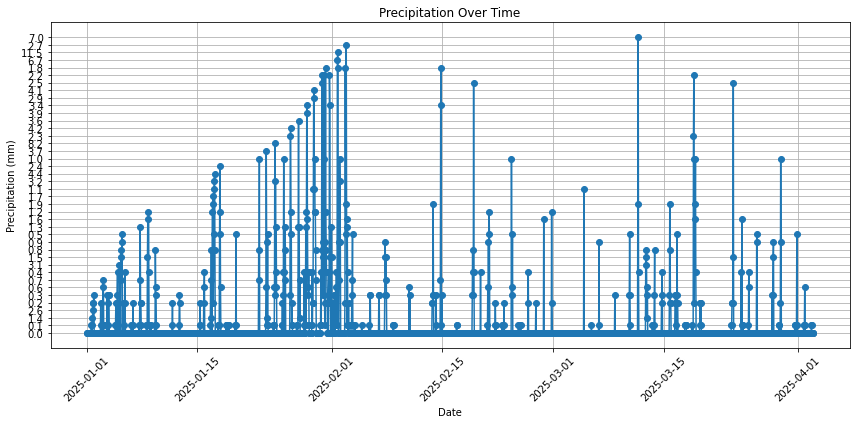

In [0]:
df_pandas = view_weatherVariables.toPandas()

df_pandas['date'] = pd.to_datetime(df_pandas['date'])

df_pandas = df_pandas.sort_values('date')

plt.figure(figsize=(12, 6))
plt.plot(df_pandas['date'], df_pandas['precipitation'], marker='o', linestyle='-')
plt.title('Precipitation Over Time')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()